# Análisis sobre datos

El archivo `TrimmedTree.root` contiene un arbol (`TTree`) con ramas (`TBranch`) que contienen los valores de medidas experimentales de un experimento de física de altas energías. 

Vamos a utilizar los datos contenidos en este archivo para ilustrar el uso de algunas clases de ROOT para realizar un análisis sobre los eventos para encontrar la resonancia del $Z^\mu$.

Primero vamos a explorar el archivo y el TTree que contiene, para saber que tipos de Clases contiene

In [1]:
from ROOT import TFile
f = TFile("TrimmedTree.root")
f.ls()

Welcome to JupyROOT 6.22/03


In [2]:
# Sabemos ahora que el TTree se llama TrimmedTree
# Ahora pongamos el TTree en una variable, para explorar el contenido
tree = f.Get("TrimmedTree")
#y visualicemos su contenido
tree.Print()

******************************************************************************
*Tree    :TrimmedTree: Trimmed Tree from ExRootAnalysis                       *
*Entries :   100000 : Total =        11046943 bytes  File  Size =    4147554 *
*        :          : Tree compression factor =   2.66                       *
******************************************************************************
*Br    0 :MuonPt    : vector<float>                                          *
*Entries :   100000 : Total  Size=    2209169 bytes  File Size  =     751202 *
*Baskets :       82 : Basket Size=      32000 bytes  Compression=   2.94     *
*............................................................................*
*Br    1 :MuonEta   : vector<float>                                          *
*Entries :   100000 : Total  Size=    2209255 bytes  File Size  =    1087361 *
*Baskets :       82 : Basket Size=      32000 bytes  Compression=   2.03     *
*..................................................

In [3]:
#Cerramos el archivo
f.Close()

Ya sabemos que el `TTree` contiene cinco ramas llamadas `MuonPt`, `MuonEta`, `MuonPhi`, `MuonE` y `MuonCharge` que no contienen la información sobre los eventos.

In [4]:
# Importamos las clases que necesitamos
from ROOT import TChain, TH1F, TLorentzVector, TCanvas

### TChain

Una cadena (`TChain`) es una colección de archivos que contienen objetos `TTree`. Cuando se crea la cadena, el primer parámetro es el nombre predeterminado para el árbol que se procesará más adelante. 

Se puede agregar un nuevo elemento en la cadena a través de la función `TChain.Add`. Una vez que se define una cadena, se pueden usar las funciones normales de `TTree` para dibujar, escanear, etc.

In [5]:
#Creamos una cadena que contendra objetos TTree de nombre 'TrimmedTree'.
DataChain = TChain("TrimmedTree")
# Le pasamos el archivo que contiene el TTree 'TrimmedTree'.
DataChain.Add("TrimmedTree.root")

1

## Eventos experimentales

Cuando un boson $Z$ decae, tiene varias posibilidades. Dado que el $Z$ es neutral, la suma de las cargas de sus productos de desintegración debe ser 0. Esto se debe a que en la naturaleza la carga se conserva. Por tanto, que $Z$ decaiga se divide entre grupos de partículas de acuerdo con leyes de conservación adicionales.

- El bosón Z se descompone en el $20\%$ de los casos en un par neutrino-antineutrino.

- En el $70\%$ de las desintegraciones $Z$, se produce un par quark-antiquark. Sumando los 6 tipos de quarks (up, down, charm, strange, top, bottom) cada uno con 3 colores da como resultado 18 posibilidades de decaimiento.

- En el $10\%$ de las desintegraciones $Z$, se producen pares cargados de leptón-antileptón. Los tres posibles tipos de pares de leptones cargados son pares electrón-positrón, muón-antimuón y tau-antitau. Cada par es aproximadamente igualmente probable. 

Como un tercio del $10\%$ de los decaimientos que esperamos del boson $Z$ va a muones, entonces si detectamos un evento con un par de muones con cargas opuestas, y su masa invariante sea de aproximadamente $90$ GeV, se puede decir entonces que hay una probabilidad alta de que estos muones provengan del decaimiento de un boson $Z$.

### Recorriendo y filtrando eventos 

Usamos el método `GetEntries` para saber cuantos datos contiene el `TTree`. Y usamos un `for` para recorrer los eventos guardados en el TTree y analizarlos.

### TLorentzVector

`TLorentzVector` es una clase general de cuadri-vectores, que se puede utilizar para la descripción de la posición y el tiempo $(x, y, z, t)$ o el momento y la energía $(p_x, p_y, p_z, E)$.

In [6]:
# Numero de eventos
print("Número de eventos en el archivo ",DataChain.GetEntries())

# Creamos un histograma para llenarlo con la información que queremos los eventos
#en este caso los eventos con dos muones de cargas iguales.
DiMuM = TH1F( 'DiMuM', 'Distribucion de masa de dos muones', 100, 60, 120 )

# Recorriendo las entradas del arbol.
for entry in DataChain:
    
    # Filtramos los eventos que tengan exactamente 2 muones
    NumberOfMuons = entry.MuonPt.size()
    if NumberOfMuons != 2: continue
        
    # Filtramos los eventos que tengan cargas de diferente signo
    if entry.MuonCharge.at(0)*entry.MuonCharge.at(1) > 0: continue
    
    # Creamos objetos TLorentzVector que son vectores de lorentz, para mirar sus propiedades
    muon1 = TLorentzVector()
    muon2 = TLorentzVector()
    
    #Usamos el método SetPtEtaPhiM para llenar los objetos muon con las entradas del TTree 
    muon1.SetPtEtaPhiM(entry.MuonPt.at(0),entry.MuonEta.at(0),entry.MuonPhi.at(0),0.106)
    muon2.SetPtEtaPhiM(entry.MuonPt.at(1),entry.MuonEta.at(1),entry.MuonPhi.at(1),0.106)
    
    # Ahora usamos el método sobrecargado + para obtener el objeto DiMuonSystem
    #de la clase TLorentzVector que contiene la suma de muon1 y munon2
    DiMuonSystem = muon1 + muon2
    
    # Llenamos el histograma con la Masa invariante
    DiMuM.Fill(DiMuonSystem.M())

Número de eventos en el archivo  100000


## Masa invariante

En física de partículas, la masa invariante $m_0$ es igual a la masa en el sistema en reposo de la partícula, y puede calcularse mediante la energía E de la partícula y su momento p medido en cualquier marco, mediante la relación energía-momento:

$m_0^2c^2=(E/c)^2-||P||^2$


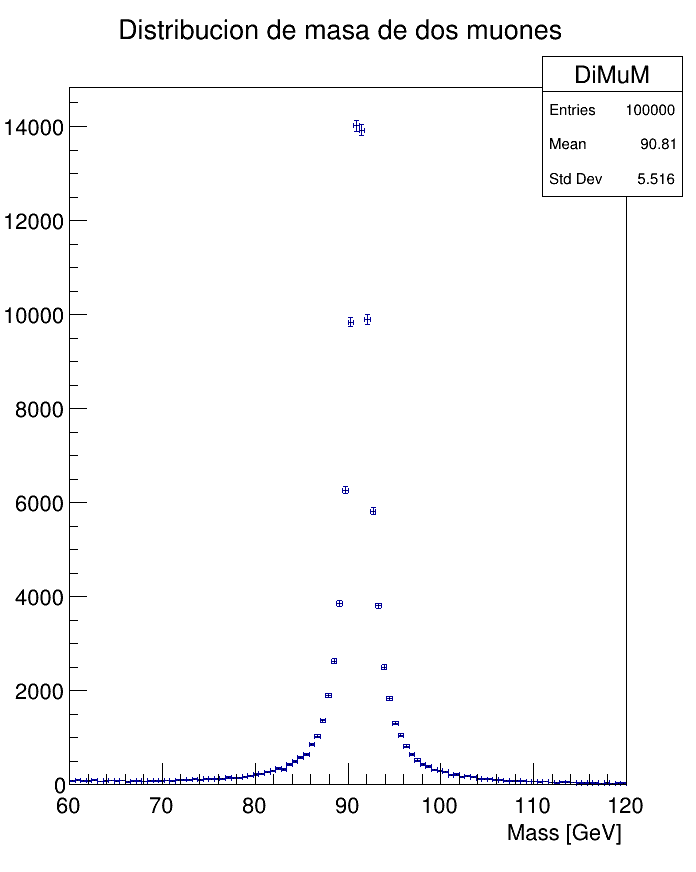

In [7]:
c1 = TCanvas( 'c1', 'The FillRandom example', 200, 10, 700, 900 )
c1.SetFillColor( 0 )
# Modifiquemos un poco el Path, para que tenga la información necesaria para entender el gráfico
DiMuM.GetXaxis().SetTitle("Mass [GeV]")
DiMuM.Draw('E1')
c1.Draw()

## RooFit

La librería `RooFit` proporciona un conjunto de herramientas para modelar la distribución esperada de eventos en un análisis físico.

Los modelos se pueden utilizar para realizar ajustes de máximo _likelihood_ a eventos no agrupados, producir gráficos y generar muestras de "Montecarlo" para diversos estudios. 

`RooFit` fue desarrollado originalmente para Colaboración __BaBar__, un experimento de física de partículas en el _Stanford Linear Accelerator Center_. 

El software está diseñado principalmente como una herramienta de análisis de datos de física de partículas, pero su naturaleza general y su arquitectura lo hace útil también para otros tipos de análisis de datos.

En este ejemplo vamos a intentar hacer un ajuste a la distribución de la masa invariante de dos muones, que encontramos anteriormente, para eso vamos a necesitar las siguientes clases pertenecientes a `RooFit`:

### RooGaussian

Implementación de la Función de Densidad de Probabilidad (PDF) Gamma para RooFit

$f(x)=\frac{(x-/mu)^{(\gamma-1)} . e^{-\frac{x-/mu}{\beta}}}{\Gamma(\gamma).\beta\gamma}$

### RooCBShape
PDF de Crystal Ball line. https://root.cern/doc/master/classRooCBShape.html

### RooRealVar
Es una variable que puede tener varios rangos.

### RooDataHist
Es una clase de contenedor para alojar datos agrupados en N-dimensiones.

In [8]:
# Primero importamos todas las clases que vamos a necesitar.
from ROOT import RooDataSet, RooGaussian, RooRealVar, RooDataHist, RooCBShape, RooFit


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



Intentemos primero hacer el ajuste usando una distribución Gaussiana.

In [9]:
#Primero definimos la variable independiente, del histograma nos damos cuenta que
# el rango de masa es de 60 GeV a 120 GeV 
mass = RooRealVar("mass", "Mass [GeV]", 60.0, 120.0);
#También vemos que la media es de 90 aproximadamente. Luego pongo esta variable
# con un rango de 85 a 95, y que su valor inicial sea 87
mean = RooRealVar("mean", "media", 87.0, 85.0, 95.0);
#con un razonamiento similar asigno el ancho de la gaussiana
sigma = RooRealVar("sigma", "ancho", 1.0, 1.0, 10.0);
#Por último declaro la PDF que voy a usar para hacer el ajuste, con sus respectivos parámetros
gaussPDF = RooGaussian("gauss", "gaussian PDF", mass, mean, sigma);

### Visualizando la PDF
Podemos tener una idea de la PDF que estamos usando si la graficamos.

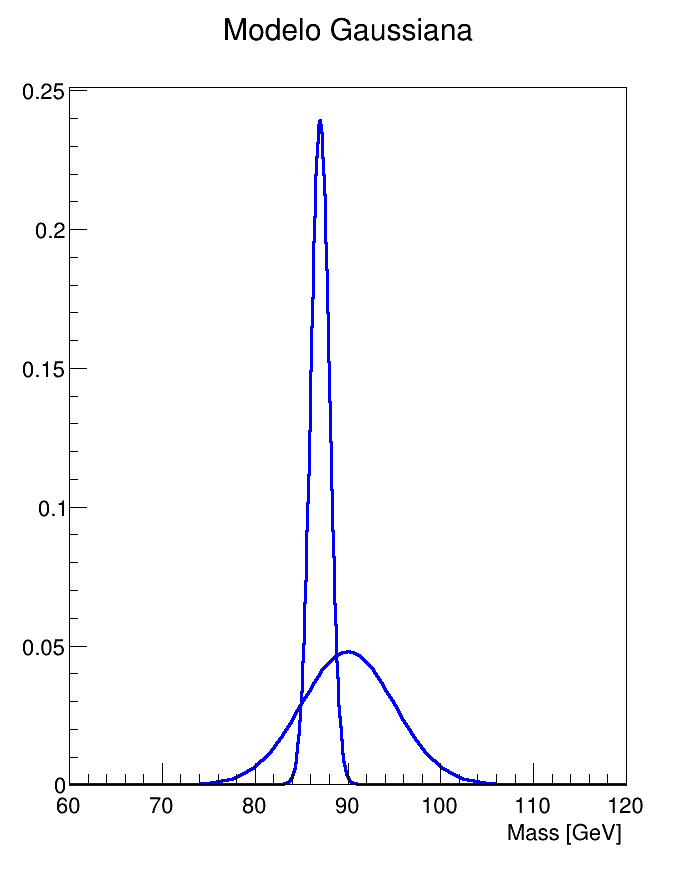

In [10]:
#Creamos un Marco para graficar (es como un Path)
massframe = mass.frame()
#Visualizo el modelo con los valores iniciales
gaussPDF.plotOn(massframe)
#Si quiero ver como se comporta dependiendo de un parámetro, se puede cambiar
#Cambiando el sigma a 5 y la media a 90
sigma.setVal(5)
mean.setVal(90)
#Grafico en el mismo marco
gaussPDF.plotOn(massframe)
# Ahora lo ponemos en el canvas y mostramos
massframe.Draw()
# Pongamos un título
massframe.SetTitle("Modelo Gaussiana")
massframe.GetYaxis().SetTitle("")
#c1.Update()
c1.Draw()

### Ajuste de datos con Roofit

Agregamos los datos desde el histograma directamente usando el constructor de `RooDataHist` que usa entrada desde TH1F. Y usando el método `fitTo` ajustamos al PDF.

In [11]:
#Datos desde histograma DiMuM
data = RooDataHist("data","Dimuon Mass",mass,DiMuM)
#Ahora se usa el método fitTo de las clases PDFs contenidas en RooFit
#para hacer el ajuste
gaussPDF.fitTo(data)
#gaussPDF.fitTo(data,ROOT.RooFit.Minimizer("Minutit2","Migrad"))

<cppyy.gbl.RooFitResult object at 0x(nil)>

[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 mean         9.00000e+01  1.00000e+00    8.50000e+01  9.50000e+01
     2 sigma        5.00000e+00  9.00000e-01    1.00000e+00  1.00000e+01
 **********
 **    3 **SET ERR         0.5
 **********
 **********
 **    4 **SET PRINT           1
 **********
 **********
 **    5 **SET STR           1
 **********
 NOW USING STRATEGY  1: TRY TO BALANCE SPEED AGAINST RELIABILITY
 **********
 **    6 **MIGRAD        1000           1
 **********
 FIRST CALL TO USER FUNCTION AT NEW START POINT, WITH IFLAG=4.
 START MIGRAD MINIMIZATION.  STRATEGY  1.  CONVERGENCE WHEN EDM .LT. 1.00e-03
 FCN=300954 FROM MIGRAD    STATUS=INITIATE        8 CALLS           9 TOTAL
                     EDM= unknown      STRATEGY= 1      NO ERROR MATRIX  

In [12]:
# Comparemos los datos con el fit
# Graficamos los datos
data.plotOn(massframe)
# Ahora graficamos el mejor ajuste
gaussPDF.plotOn(massframe)
massframe.Draw() 

[#1] INFO:Plotting -- RooPlot::updateFitRangeNorm: New event count of 95521 will supercede previous event count of 1 for normalization of PDF projections


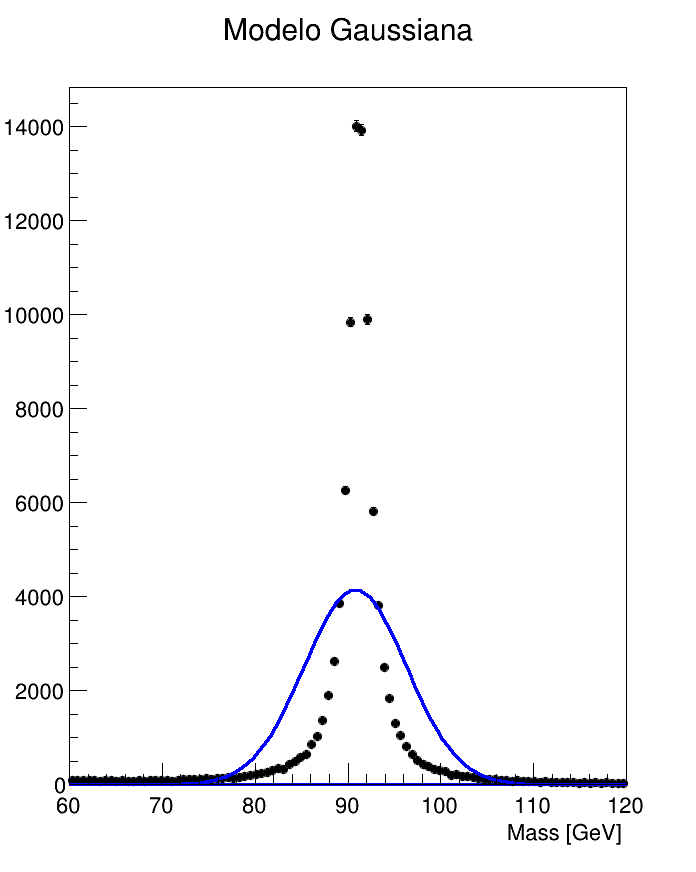

In [13]:
c1.Draw()

Ahora intentemos con otra PDF llamada cristall ball line

In [14]:
#Definimos los parametros de dicha PDF y sus rangos 
media = RooRealVar("media"," mean",60.0,120.0);
ancho = RooRealVar("ancho","width",1.0,10.0);
n = RooRealVar("n","n",1,50);                                                                                                                                                                    
alpha = RooRealVar("alpha","alpha",0,50);                                                                                                                                                        
SigCB = RooCBShape("SigCB"," SignalCB PDF",mass,media,ancho,alpha,n);

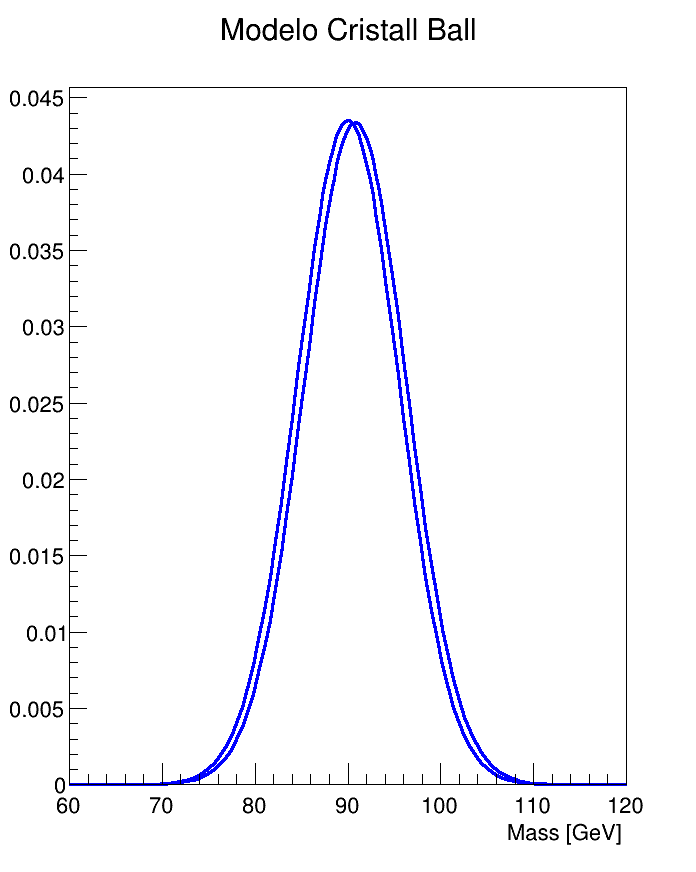

In [15]:
#Creamos un Marco para graficar (es como un Path)
Newframe = mass.frame()
#Visualizo el modelo con los valores iniciales
SigCB.plotOn(Newframe)
#Si quiero ver como se comporta dependiendo de un parámetro
media.setVal(90)
ancho.setVal(3)
n.setVal(1)
alpha.setVal(5)
#Grafico en el mismo marco
gaussPDF.plotOn(Newframe)
# Ahora lo ponemos en el canvas y mostramos
Newframe.Draw()
# Pongamos un título
Newframe.SetTitle("Modelo Cristall Ball")
Newframe.GetYaxis().SetTitle("")
#c1.Update()
c1.Draw()

In [16]:
#Ahora se usa el método fitTo de las clases PDFs contenidas en RooFit
#para hacer el ajuste
SigCB.fitTo(data,RooFit.Minimizer("Minutit2","Migrad"))

<cppyy.gbl.RooFitResult object at 0x(nil)>

[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 alpha        5.00000e+00  2.50000e+00    0.00000e+00  5.00000e+01
     2 ancho        3.00000e+00  9.00000e-01    1.00000e+00  1.00000e+01
     3 media        9.00000e+01  6.00000e+00    6.00000e+01  1.20000e+02
     4 n            1.00000e+00  4.90000e+00    1.00000e+00  5.00000e+01
 MINUIT WARNING IN PARAM DEF
 ============== STARTING VALUE IS AT LIMIT.
 MINUIT WARNING IN PARAMETR
 ============== VARIABLE4 IS AT ITS LOWER ALLOWED LIMIT.
 MINUIT WARNING IN PARAMETR
 ============== VARIABLE4 BROUGHT BACK INSIDE LIMITS.
 **********
 **    3 **SET ERR         0.5
 **********
 **********
 **    4 **SET PRINT           1
 **********
 **********
 **    5 **SET STR           1
 **********
 NOW USING STRATEGY  1: TRY TO BALA

Warning in <ROOT::Math::FitConfig::CreateMinimizer>: Could not create the Minutit2 minimizer. Try using the minimizer Minuit
Info in <ROOT::Math::Fitter::DoUpdateMinimizerOptions: >: Using now Minutit2 / Migrad
Warning in <ROOT::Math::FitConfig::CreateMinimizer>: Could not create the Minutit2 minimizer. Try using the minimizer Minuit


[#1] INFO:Plotting -- RooPlot::updateFitRangeNorm: New event count of 95521 will supercede previous event count of 1 for normalization of PDF projections


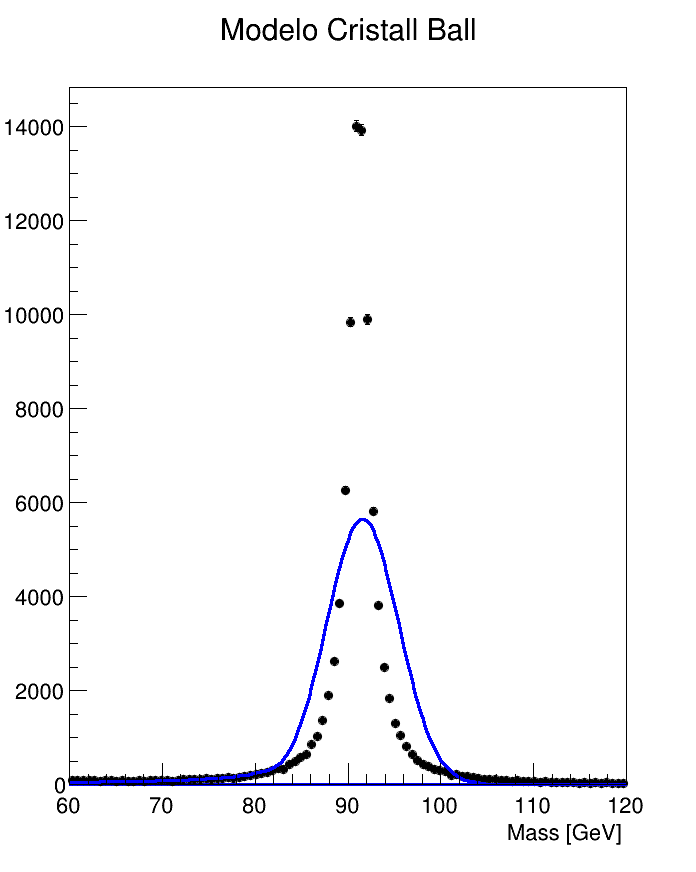

In [17]:
# Comparemos los datos con el fit
# Graficamos los datos

data.plotOn(Newframe)
# Ahora graficamos el mejor ajuste
SigCB.plotOn(Newframe)
Newframe.Draw() 
c1.Draw()